# The Goal

Our goal here is to build a personal audio search engine like «Shazam». 

Based on http://willdrevo.com/fingerprinting-and-audio-recognition-with-python/

In [1]:
import glob
import os
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
%matplotlib  inline

from tqdm import tqdm
from lib.helpers.files import loadfile
from lib.fingerprinting import fingerprint

pd.set_option("display.max_rows", 10)
pd.set_option('display.max_columns', 1100)

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/home/levabd/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Step 1: Defining and Explore our Sound Descriptor

## Music as a signal

As a computer scientist, my familiarity with the Fast Fourier Transform (FFT) was only that it was a cool way to mutliply polynomials in O(nlog(n)) time. Luckily it is much cooler for doing signal processing, its canonical usage.

Music, it turns out, is digitally encoded as just a long list of numbers. In an uncompressed .wav file, there are a lot of these numbers - 44100 per second per channel. This means a 3 minute long song has almost 16 million samples.

> 3 min * 60 sec * 44100 samples per sec * 2 channels = 15,876,000 samples

A channel is a separate sequence of samples that a speaker can play. Think of having two earbuds - this is a “stereo”, or two channel, setup. A single channel is called “mono”. Today, modern surround sound systems can support many more channels. But unless the sound is recorded or mixed with the same number of channels, the extra speakers are redundant and some speakers will just play the same stream of samples as other speakers.

## Sampling

Why 44100 samples per second? The mysterious choice of 44100 samples per second seems quite arbitrary, but it relates to the Nyquist-Shannon Sampling Theorum. This is a long, mathematical way to say that there is a theoretical limit on the maximum frequency we can capture accurately when recording. This maximum frequency is based on how fast we sample the signal.

If this doesn’t make sense, think about watching a fan blade that makes a full revolution at a rate of exactly once per second (1 Hz). Now imagine keeping your eyes closed, but opening them briefly once per second. If the fan still happens to be making exactly a full revolution every 1 second as well, it will appear as though the fan blade hasn’t moved! Each time you open your eyes, the blade happens to be in the same spot. But there’s a problem. In fact, as far as you know, the fan blade could be making 0, 1, 2, 3, 10, 100, or even 1 million spins per second and you would never know - it would still appear stationary! Thus in order to be assured you are correctly sampling (or “seeing”) higher frequencies (or “spins”), you need to sample (or “open your eyes”) more frequently. To be exact, we need to sample twice as frequently as the frequency we want to see to make sure we’re detecting it.

In the case of recording audio, the accepted rule is that we’re OK missing out on frequencies above 22050 Hz since humans can’t even hear frequencies above 20,000 Hz. Thus by Nyquist, we have to sample twice that:

> Samples per sec needed = Highest-Frequency * 2 = 22050 * 2 = 44100

The MP3 format compresses this in order to 

1. save space on your hard drive
2. irritate audiophiles, but a pure .wav formatted file on your computer is just a list of 16 bit integers (with a small header).

## Spectrograms and Peak Finding

Since these samples are a signal of sorts, we can repeatedly use an FFT over small windows of time in the song’s samples to create a spectrogram of the song. 

We define a peak as a (time, frequency) pair corresponding to an amplitude value which is the greatest in a local “neighborhood” around it. Other (time, frequency) pairs around it are lower in amplitude, and thus less likely to survive noise.

Finding peaks is an entire problem itself. I ended up treating the spectrogram as an image and using the image processing toolkit and techniques from scipy to find peaks. A combination of a high pass filter (accentuating high amplitudes) and scipy local maxima structs did the trick.

Once we’ve extracted these noise-resistant peaks, we have found points of interest in a song that identify it. We are effectively “squashing” the spectrogram down once we’ve found the peaks. The amplitudes have served their purpose, and are no longer needed.

## Let's see «Bohemian Rhapsody» part (from 3.13 to 3.20) peaks by channels

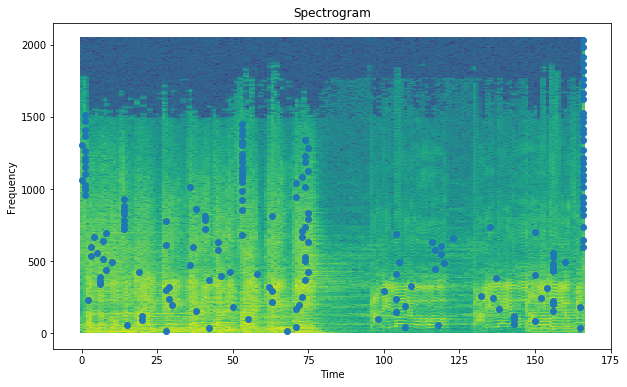

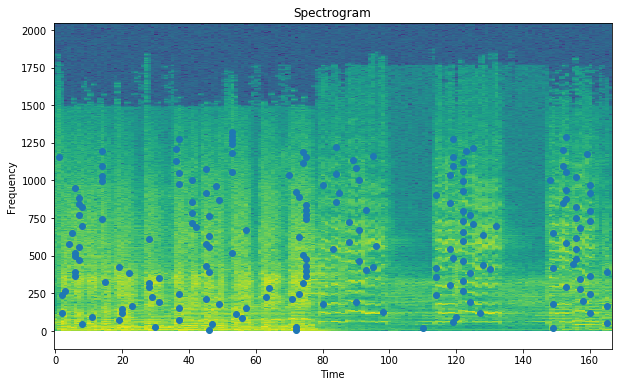

In [2]:
channels, fs = loadfile("query/Bohemian Rhapsody(cutted).mp3")
for _, channel in enumerate(channels):
    fingerprint(channel, Fs=fs, debug=True)

As you can see, it’s just a 2D array with amplitude as a function of time and frequency. The FFT shows us the strength (amplitude) of the signal at that particular frequency, giving us a column. If we do this enough times with our sliding window of FFT, we put them together and get a 2D array spectrogram.

It’s important to note that the frequency and time values are discretized, each representing a “bin”, while the amplitudes are real valued. The color shows the real value (yellow -> higher, blue -> lower) of the amplitude at the discretized (time, frequency) coordinate.

As a thought experiment, if we were to record and create a spectrogram of a single tone, we’d get a straight horizontal line at the frequency of the tone. This is because the frequency does not vary from window to window.

You’ll notice there are a lot of peaks. Two hundred for 7 second and tens of thousands per song, actually. The beauty is that since we’ve done away with amplitude, we only have two things, time and frequency, which we’ve conviently made into discrete, integer values. We’ve binned them, essentially.

We have a somewhat schizophrenic situation: on one hand, we have a system that will bin peaks from a signal into discrete (time, frequency) pairs, giving us some leeway to survive noise. On the other hand, since we’ve discretized, we’ve reduced the information of the peaks from infinite to finite, meaning that peaks found in one song could (hint: will!) collide, emitting the pairs as peaks extracted from other songs. Different songs can and most likely will emit the same peaks!

By looking at our spectrogram peaks and combining peak frequencies along with their time difference between them, we can create a hash, representing a unique fingerprint for this song.

`hash(frequencies of peaks, time difference between peaks) = fingerprint hash value`

# Step 2: Learning. Extracting Features from Our Dataset

The fingerprints has the following structure:

- soundID
- hash
- time offset

In [ ]:
output = open("indexes/music.idx", "w")

# use glob to grab the mp3 paths and loop over them
for musicPath in tqdm(glob.glob("dataset/*.mp3")):

    soundID = musicPath[musicPath.rfind("/") + 1:]
    
    channels, fs = loadfile(musicPath)
 
    result = set()

    for _, channel in enumerate(channels):
        hashes = set(fingerprint(channel, Fs=fs))
        result |= hashes

    features = [str(f) for f in result]
    print(len(music_index))
    output.write("%s,%s\n" % (soundID, ",".join(features)))

output.close()

print("Indexes saved with size(Bytes): {}".format(os.stat('indexes/music.idx').st_size))

  0%|          | 0/77 [00:00<?, ?it/s]/home/levabd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/levabd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  1%|▏         | 1/77 [1:19:17<100:25:33, 4757.02s/it]

220178


/home/levabd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/levabd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  3%|▎         | 2/77 [4:22:48<138:11:46, 6633.42s/it]

406840


/home/levabd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  4%|▍         | 3/77 [7:35:26<166:43:13, 8110.72s/it]

538636


/home/levabd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/home/levabd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


### 7 Hours for indexing 3 sound mean 10 days for indexing all dataset (only 77 songs)
### Pandas is insanely slow. So I need another plan

In [2]:
%%time

music_index_list = []

with open("indexes/music_idx.idx") as f:
    song_idxs = f.readlines()

for song_idx in tqdm(song_idxs):
    song = song_idx.split(',', 1)
    song_id = song[0]
    song_hashes = song[1][1:][:-1]  # Delete first and last brackets
    for hash_pair in song_hashes.split('),('):
        hash_pair_list = hash_pair.split(',')
        music_index_list.append(
                 {
                     'sound_id': song_id,
                     'hash': hash_pair_list[0][1:][:-1], 
                     'time_offset': hash_pair_list[1]
                 })

100%|██████████| 77/77 [00:16<00:00,  4.67it/s]

CPU times: user 15.4 s, sys: 1.61 s, total: 17.1 s
Wall time: 20.1 s


## Much better than pandas

Here our song fingerprint database

In [3]:
music_index = pd.DataFrame(music_index_list)
music_index

,hash,sound_id,time_offset
0,533f4ecdecf7bc0ffecd,01 - A Kind Of Magic.mp3,2798
1,5539c19c573f7cc3373d,01 - A Kind Of Magic.mp3,5418
2,82b7da9268b760bf87c0,01 - A Kind Of Magic.mp3,5140
3,216495af260ed2c75931,01 - A Kind Of Magic.mp3,2643
4,7f9894fd715dd709eb8d,01 - A Kind Of Magic.mp3,1065
...,...,...,...
15335216,6c5b0838185c3e32a193,[01] Scandal - Warrior.mp3,14
15335217,24a915a5eba66665a1fd,[01] Scandal - Warrior.mp3,2290
15335218,d7390fad2e71e30a7d27,[01] Scandal - Warrior.mp3,3048
15335219,25f2256df5baa2b2b0a0,[01] Scandal - Warrior.mp3,1106


# Step 3: The Searcher

Great, so now we’ve get part of audio track, performed FFT in overlapping windows over the length of the song, extracted peaks, and formed fingerprints. Now what?

Assuming we’ve already performed this fingerprinting on known tracks, ie we have already inserted our fingerprints into the database labeled with song IDs, we can simply match.

`def align_matches(matches):`

What does it mean for hashes to be aligned? Let’s think about the sample that we are listening to as a subsegment of the original audio track. Once we do this, the hashes we extract out of the sample will have an offset that is relative to the start of the sample.

The problem of course, is that when we originally fingerprinted, we recorded the absolute offset of the hash. The relative hashes from the sample and the absolute hashes from the database won’t ever match unless we started recording a sample from exactly the start of the song. Pretty unlikely.

But while they may not be the same, we do know something about the matches from the real signal behind the noise. We know all the relative offsets will be the same distance apart. This requires the assumption that the track is being played and sampled at the same speed it was recorded and released in the studio. Actually, we’d be out of luck anyway in the case the playback speed was different, since this would affect the frequency of the playback and therefore the peaks in the spectrogram. At any rate, the playback speed assumption is a good (and important) one.

Under this assumption, for each match we calculate a difference between the offsets:

> difference = database offset from original track - sample offset from recording

which will always yield a postiive integer since the database track will always be at least the length of the sample. All of the true matches with have this same difference. Thus our matches from the database are altered to look like:

> (song_id, difference)

Now we simply look over all of the matches and predict the song ID for which the largest count of a difference falls. This is easy to imagine if you visualize it as a histogram.

And that’s all there is to it!

In [4]:
def find_matches(samples, Fs):
    hashes = fingerprint(samples, Fs=Fs)
    
    matches = []
    for hash, offset in tqdm(hashes):
        for row, match in music_index[music_index.hash == hash].iterrows():
            matches.extend((music_index.iloc[row]['sound_id'], int(music_index.iloc[row]['time_offset']) - offset))
    
    return matches
    
def align_matches(matches):
    """
    Finds hash matches that align in time with other matches and finds
    consensus about which hashes are "true" signal from the audio.
    Returns a dictionary with match information.
    """
    # align by diffs
    diff_counter = {}
    largest = 0
    second_largest = 0
    third_largest = 0
    largest_count = 0
    song_id = -1
    second_song_id = -1
    third_song_id = -1
    for idx, sid in tqdm(enumerate(matches[0::2])):
        diff = matches[1::2][idx]
        if diff not in diff_counter:
            diff_counter[diff] = {}
        if sid not in diff_counter[diff]:
            diff_counter[diff][sid] = 0
        diff_counter[diff][sid] += 1

        if diff_counter[diff][sid] > largest_count:
            third_largest = second_largest
            second_largest = largest
            largest = diff
            largest_count = diff_counter[diff][sid]
            third_song_id = second_song_id
            second_song_id = song_id
            song_id = sid
    mathing_search = [
        { "song_id": song_id, "time_offset": second_distance(largest) },
        { "song_id": second_song_id, "time_offset": second_distance(second_largest) },
        { "song_id": third_song_id, "time_offset": second_distance(third_largest) }
    ]

    return mathing_search
    
def search_matches(queryFile):
    channels, fs = loadfile(queryFile)
    
    matches = []
    for channel in channels:
        matches.extend(find_matches(channel, fs))
    return matches
    
def second_distance(offset):
    return round(float(offset) / 44100 * 4096 * 0.5, 5)  # DEFAULT_FS * DEFAULT_WINDOW_SIZE * DEFAULT_OVERLAP_RATIO

# Step 4: Performing a Search

Let's search by 7 second of Queen's «Bohemian Rhapsody» 

In [5]:
%%time

matches = search_matches("query/Bohemian Rhapsody(cutted).mp3")

2387it [1:06:07,  1.65s/it]
2611it [1:11:57,  1.64s/it]

CPU times: user 2h 17min 31s, sys: 8.64 s, total: 2h 17min 40s
Wall time: 2h 18min 6s


In [6]:
del music_index_list
del music_index

In [7]:
len(matches)

16908

In [8]:
align_matches(matches)

8454it [00:00, 33080.30it/s]


[{'song_id': '01 - Bohemian Rhapsody.mp3', 'time_offset': 193.09714},
 {'song_id': '01 - Bohemian Rhapsody.mp3', 'time_offset': 193.09714},
 {'song_id': '01 - Bohemian Rhapsody.mp3', 'time_offset': 193.09714}]

Try to see another result (similar songs)

In [11]:
df = pd.DataFrame(matches[0::2], columns=['sound_id'])

grouped = df.groupby('sound_id').sum().reset_index()
grouped.sort_values('sound_id', ascending=False)

grouped

,sound_id
0,01 - A Kind Of Magic.mp3
1,01 - Bohemian Rhapsody.mp3
2,01 - Born To Be Wild.mp3
3,01 - Breaking The Law.mp3
4,01 - I'm Eighteen.mp3
...,...
72,[01] Scandal - Warrior.mp3
73,rapira_-_breaking_me_down_(zaycev.net).mp3
74,scorpions_-_no_pain_no_gain.mp3
75,scorpions___humanity__www.mp3_online.com.ua_.mp3


# Conclusion

To truly get the benefit of an audio fingerprinting system, it can’t take a long time to fingerprint. It’s a bad user experience, and furthermore, a user may only decide to try to match the song with only a few precious seconds of audio left before the radio station goes to a commercial break.